In [1]:
import math
import os
import pickle
import pandas as pd

import numpy as np

from matplotlib import pyplot as plt

import torch

In [2]:
# https://github.com/rdbraatz/data-driven-prediction-of-battery-cycle-life-before-capacity-degradation/blob/master/Load%20Data.ipynb

remove_keys = [
  # FOLLOWS THE ORIGINAL REPO
  # remove batteries that do not reach 80% capacity
  'b1c8', 'b1c10', 'b1c12', 'b1c13', 'b1c22',      
  # remove batteries from batch 2 that are moved to batch 1
  'b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16',      
  # remove noisy channels from batch3
  'b3c37', 'b3c2', 'b3c23', 'b3c32', 'b3c42', 'b3c43',
  
  # NEWLY DELETED HERE
  # remove outlier with abnormal capacity
  'b1c0', 'b1c18', 'b2c12', 'b2c44'
]
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482]

temperature_feature_interval = 1
current_feature_interval = 1

cap_outlier_diff_threshold = 0.015

curve_ratio_min = 0.5
curve_ratio_max = 0.99
curve_ratio_steps = 9
curve_ratio_digits = 2
curve_ratio_step_size = (curve_ratio_max - curve_ratio_min) / curve_ratio_steps

In [3]:
data_dir_path = '/home/keilong/Downloads/Stanford University battery dataset'
batch1 = pickle.load(open(os.path.join(data_dir_path,'batch1.pkl'), 'rb'))
batch2 = pickle.load(open(os.path.join(data_dir_path,'batch2.pkl'), 'rb'))
batch3 = pickle.load(open(os.path.join(data_dir_path,'batch3.pkl'), 'rb'))

for i, bk in enumerate(batch1_keys):
  batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
  for j in batch1[bk]['summary'].keys():
    if j == 'cycle':
      batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
    else:
      batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
  last_cycle = len(batch1[bk]['cycles'].keys())
  for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
    batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]
    
batch = {**batch1, **batch2, **batch3}
for key in remove_keys:
  del batch[key]

In [4]:
max_temps = []
min_temps = []
for key in batch.keys():
  max_temps.append(np.max(batch[key]['summary']['Tmax']))
  min_temps.append(np.min(batch[key]['summary']['Tmin'][np.nonzero(batch[key]['summary']['Tmin'])]))
max_temp = np.max(max_temps)
min_temp = np.min(min_temps)

max_currents = []
min_currents = []
for key in batch.keys():
  for cycle in batch[key]['cycles'].keys():
    max_currents.append(np.max(batch[key]['cycles'][cycle]['I']))
    min_currents.append(np.min(batch[key]['cycles'][cycle]['I']))
max_current = np.max(max_currents)
min_current = np.min(min_currents)

In [5]:
batch.keys()

dict_keys(['b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c10', 'b2c11', 'b2c13', 'b2c14', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c45', 'b2c46', 'b2c47', 'b3c0', 'b3c1', 'b3c3', 'b3c4', 'b3c5', 'b3c6', 'b3c7', 'b3c8', 'b3c9', 'b3c10', 'b3c11', 'b3c12', 'b3c13', 'b3c14', 'b3c15', 'b3c16', 'b3c17', 'b3c18', 'b3c19', 'b3c20', 'b3c21', 'b3c22', 'b3c24', 'b3c25', 'b3c26', 'b3c27', 'b3c28', 'b3c29', 'b3c30', 'b3c31', 'b3c33', 'b3c34', 'b3c3

In [6]:
batch['b1c1']['cycles']['3']['t']

array([0.00000000e+00, 2.71166667e-03, 3.15333333e-03, ...,
       5.43692000e+01, 5.43778267e+01, 5.43858433e+01])

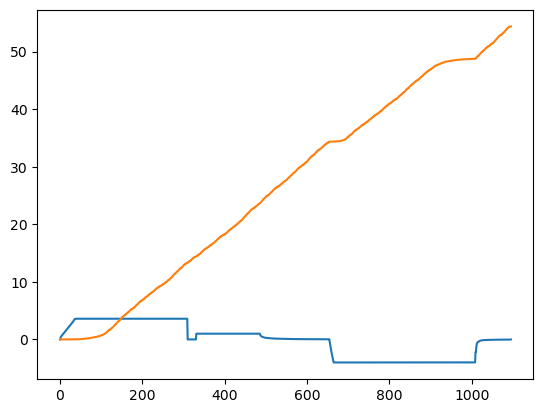

In [7]:
plt.plot(batch['b1c1']['cycles']['333']['I'])
plt.plot(batch['b1c1']['cycles']['333']['t'])

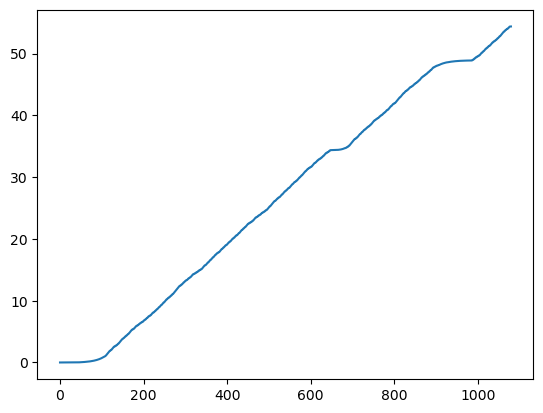

In [8]:
plt.plot(batch['b1c1']['cycles']['3']['t'])

In [9]:
data_path = '/home/keilong/Downloads/LG 18650HG2 Li-ion Battery Data and Example Deep Neural Network xEV SOC Estimator Script/LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020'

temp_to_test = ['40degC', '25degC', '10degC']

# loop all csv in data_path and append all rows in one dataframe
df = pd.DataFrame()
for dir in os.listdir(data_path):
    if not os.path.isdir(os.path.join(data_path, dir)):
        continue
    if dir not in temp_to_test:
        continue
    for file in os.listdir(os.path.join(data_path, dir)):
        if not file.endswith('.csv'):
            continue
        file_path = os.path.join(data_path, dir, file)
        # print(file_path)
        time_stamp_line_idx = 0

        with open(file_path) as f:
            for i, line in enumerate(f):
                if 'Time Stamp' in line:
                    time_stamp_line_idx = i
                    break
        
        new_df = pd.read_csv(file_path, 
                                skiprows=time_stamp_line_idx + 2, 
                                header=None,
                                index_col=False,
                                names=['Time Stamp',
                                    'Step',
                                    'Status',
                                    'Prog Time',
                                    'Step Time',
                                    'Cycle',
                                    'Cycle Level',
                                    'Procedure',
                                    'Voltage',
                                    'Current',
                                    'Temperature',
                                    'Capacity',
                                    'WhAccu',
                                    'Cnt'],
                                )
        new_df = new_df.drop_duplicates()
        
        # remove date only rows
        new_df = new_df[new_df['Time Stamp'].str.len() > 10]
        
        # print(file_path)
        new_df['Timestamp'] = pd.to_datetime(new_df['Time Stamp'], format='%m/%d/%Y %I:%M:%S %p').apply(lambda x: x.timestamp())
        
        # new_df['Timestamp'] = pd.to_datetime(new_df['Time Stamp']).apply(lambda x: x.timestamp())
        
        new_df['Exp Temperature'] = dir
        new_df['Cycle Name'] = file[:-4]
        new_df['Exp Name'] = dir + ': ' + file[:-4]
        
        new_df['Index'] = new_df.index
        
        df = pd.concat([df, new_df])
                

df = df[df['Status'].isin([
                           'DCH', 
                           'PAU', 
                           'CHA', 
                        #    'STO',
                           'TABLE', 
                        #    'MSG'
                           ])]
                
df.sort_values(by=['Timestamp', 'Index'], inplace=True)

df['Status Consecutive'] = (df['Status'] != df['Status'].shift()).cumsum()
df['Status Unique'] = df['Status'] + df['Status Consecutive'].astype(str)

cycle_count = 0
for key, group in df.groupby('Exp Name', sort=False):
  df.loc[group.index, 'Cycle Num'] = cycle_count
  cycle_count += 1      
  
df.reset_index(drop=True, inplace=True)
df['Index'] = df.index


In [10]:
df.to_csv('all_data.csv', index=False)

In [11]:
df

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,...,WhAccu,Cnt,Timestamp,Exp Temperature,Cycle Name,Exp Name,Index,Status Consecutive,Status Unique,Cycle Num
0,10/25/2018 4:09:59 AM,4,PAU,00:01:00.013,00:01:00.002,0,0,NN_Char_Charge,3.10125,0.0,...,0.00000,11.0,1.540441e+09,25degC,549_Charge,25degC: 549_Charge,0,1,PAU1,102.0
1,10/25/2018 4:10:59 AM,4,PAU,00:02:00.013,00:02:00.002,0,0,NN_Char_Charge,3.10192,0.0,...,0.00000,11.0,1.540441e+09,25degC,549_Charge,25degC: 549_Charge,1,1,PAU1,102.0
2,10/25/2018 4:11:59 AM,4,PAU,00:03:00.015,00:03:00.004,0,0,NN_Char_Charge,3.10260,0.0,...,0.00000,11.0,1.540441e+09,25degC,549_Charge,25degC: 549_Charge,2,1,PAU1,102.0
3,10/25/2018 4:12:59 AM,4,PAU,00:04:00.014,00:04:00.003,0,0,NN_Char_Charge,3.10344,0.0,...,0.00000,11.0,1.540441e+09,25degC,549_Charge,25degC: 549_Charge,3,1,PAU1,102.0
4,10/25/2018 4:13:59 AM,4,PAU,00:05:00.013,00:05:00.002,0,0,NN_Char_Charge,3.10412,0.0,...,0.00000,11.0,1.540441e+09,25degC,549_Charge,25degC: 549_Charge,4,1,PAU1,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662574,11/26/2018 12:40:49 PM,43,PAU,10:27:01.775,00:09:59.603,0,0,LG_HG2_CyclesA,3.27757,0.0,...,-8.46247,2.0,1.543236e+09,10degC,582_LA92,10degC: 582_LA92,2662574,843,PAU843,102.0
2662575,11/26/2018 12:40:49 PM,43,PAU,10:27:01.874,00:09:59.702,0,0,LG_HG2_CyclesA,3.27757,0.0,...,-8.46247,2.0,1.543236e+09,10degC,582_LA92,10degC: 582_LA92,2662575,843,PAU843,102.0
2662576,11/26/2018 12:40:49 PM,43,PAU,10:27:01.975,00:09:59.803,0,0,LG_HG2_CyclesA,3.27757,0.0,...,-8.46247,2.0,1.543236e+09,10degC,582_LA92,10degC: 582_LA92,2662576,843,PAU843,102.0
2662577,11/26/2018 12:40:49 PM,43,PAU,10:27:02.076,00:09:59.904,0,0,LG_HG2_CyclesA,3.27757,0.0,...,-8.46247,2.0,1.543236e+09,10degC,582_LA92,10degC: 582_LA92,2662577,843,PAU843,102.0


In [12]:
# test_df = pd.read_csv('/home/keilong/Downloads/Samsung INR21700 30T 3Ah Li-ion Battery Data/40degC/697_Dis_2C.csv', 
#                                 skiprows=time_stamp_line_idx + 2, 
#                                 header=None,
#                                 index_col=False,
#                                 names=['Time Stamp',
#                                     'Step',
#                                     'Status',
#                                     'Prog Time',
#                                     'Step Time',
#                                     'Cycle',
#                                     'Cycle Level',
#                                     'Procedure',
#                                     'Voltage',
#                                     'Current',
#                                     'Temperature',
#                                     'Capacity',
#                                     'WhAccu',
#                                     'Cnt'],)

# test_df.index.name = 'Index'
# test_df['Timestamp'] = pd.to_datetime(test_df['Time Stamp']).apply(lambda x: x.timestamp())

# test_df.sort_values(by=['Timestamp', 'Index'], inplace=True)

# test_df.to_csv('test.csv', index=False)

In [13]:
for key, group in df.groupby(['Exp Name', 'Status Unique'], sort=False):
  print(key)

('25degC: 549_Charge', 'PAU1')
('25degC: 549_Charge', 'CHA2')
('25degC: 549_Charge', 'PAU3')
('25degC: 549_HPPC', 'PAU3')
('25degC: 549_HPPC', 'DCH4')
('25degC: 549_HPPC', 'PAU5')
('25degC: 549_HPPC', 'CHA6')
('25degC: 549_HPPC', 'PAU7')
('25degC: 549_HPPC', 'DCH8')
('25degC: 549_HPPC', 'PAU9')
('25degC: 549_HPPC', 'CHA10')
('25degC: 549_HPPC', 'PAU11')
('25degC: 549_HPPC', 'DCH12')
('25degC: 549_HPPC', 'PAU13')
('25degC: 549_HPPC', 'CHA14')
('25degC: 549_HPPC', 'PAU15')
('25degC: 549_HPPC', 'DCH16')
('25degC: 549_HPPC', 'PAU17')
('25degC: 549_HPPC', 'CHA18')
('25degC: 549_HPPC', 'PAU19')
('25degC: 549_HPPC', 'DCH20')
('25degC: 549_HPPC', 'PAU21')
('25degC: 549_HPPC', 'DCH22')
('25degC: 549_HPPC', 'PAU23')
('25degC: 549_HPPC', 'CHA24')
('25degC: 549_HPPC', 'PAU25')
('25degC: 549_HPPC', 'DCH26')
('25degC: 549_HPPC', 'PAU27')
('25degC: 549_HPPC', 'CHA28')
('25degC: 549_HPPC', 'PAU29')
('25degC: 549_HPPC', 'DCH30')
('25degC: 549_HPPC', 'PAU31')
('25degC: 549_HPPC', 'CHA32')
('25degC: 549_

In [13]:
cycle_configs = cycle_configs = [
  [('40degC: 697_C20DisCh', 'ALL'), ('40degC: 697_C20DisCh', 'CHA3')],
  [('40degC: 697_Dis_0p5C', 'ALL'), ('40degC: 697_Dis_0p5C', 'CHA7')],
  [('40degC: 697_Dis_2C', ['DCH9', 'PAU10', 'CHA11']), ('40degC: 697_Dis_2C', 'CHA11')],
  # very short charging cycle
  # [('40degC: 697_Dis_2C', ['PAU14', 'DCH15', 'PAU16', 'CHA17']), ('40degC: 697_Dis_2C', 'CHA17')],
  [('40degC: 710_UDDS', 'ALL'), ('40degC: 710_Charge3', 'CHA467')],
  [('40degC: 710_HWFET', 'ALL'), ('40degC: 710_Charge4', 'CHA471')],
  [('40degC: 710_LA92', 'ALL'), ('40degC: 710_Charge5', 'CHA475')],
  [('40degC: 710_US06', 'ALL'), ('40degC: 710_Charge6', 'CHA479')],
  [('40degC: 710_Mixed1', 'ALL'), ('40degC: 710_Charge7', 'CHA483')],
  [('40degC: 710_Mixed2', 'ALL'), ('40degC: 710_Charge8', 'CHA487')],
  [('40degC: 722_Cap_1C', 'ALL'), ('40degC: 722_Charge10', 'CHA493')],
  [('40degC: 722_Mixed3', 'ALL'), ('40degC: 722_Charge11', 'CHA497')],
  [('40degC: 722_Mixed4', 'ALL'), ('40degC: 722_Charge12', 'CHA501')],
  [('40degC: 722_Mixed5', 'ALL'), ('40degC: 722_Charge13', 'CHA505')],
  [('40degC: 722_Mixed6', 'ALL'), ('40degC: 722_Charge14', 'CHA509')],
  [('40degC: 722_Mixed7', 'ALL'), ('40degC: 722_Charge15', 'CHA513')],
  [('40degC: 722_Mixed8', 'ALL'), ('40degC: 722_Charge16', 'CHA517')],

  # abnormally high charged capacity
  # [('25degC: 729_C20DisCh', 'ALL'), ('25degC: 729_C20DisCh', 'CHA1863')],
  [('25degC: 729_Dis_0p5C', 'ALL'), ('25degC: 729_Dis_0p5C', 'CHA971')],
  [('25degC: 729_Dis_2C', ['DCH973', 'PAU974', 'CHA975']), ('25degC: 729_Dis_2C', 'CHA975')],
  [('25degC: 729_Dis_2C', ['PAU976', 'DCH977', 'PAU978', 'CHA979']), ('25degC: 729_Dis_2C', 'CHA979')],
  [('25degC: 734_Cap_1C', 'ALL'), ('25degC: 734_Charge2', 'CHA985')],
  [('25degC: 734_UDDS', 'ALL'), ('25degC: 734_Charge3', 'CHA989')],
  [('25degC: 734_HWFET', 'ALL'), ('25degC: 734_Charge4', 'CHA993')],
  [('25degC: 734_LA92', 'ALL'), ('25degC: 734_Charge5', 'CHA997')],
  [('25degC: 734_US06', 'ALL'), ('25degC: 734_Charge6', 'CHA1001')],
  [('25degC: 734_Mixed1', 'ALL'), ('25degC: 734_Charge7', 'CHA1005')],
  [('25degC: 734_Mixed2', 'ALL'), ('25degC: 734_Charge8', 'CHA1009')],
  [('25degC: 740_Mixed3', 'ALL'), ('25degC: 740_Charge11', 'CHA1017')],
  [('25degC: 740_Mixed4', 'ALL'), ('25degC: 740_Charge12', 'CHA1021')],
  [('25degC: 740_Mixed5', 'ALL'), ('25degC: 740_Charge13', 'CHA1025')],
  [('25degC: 740_Mixed6', 'ALL'), ('25degC: 740_Charge14', 'CHA1029')],
  [('25degC: 740_Mixed7', 'ALL'), ('25degC: 740_Charge15', 'CHA1033')],
  [('25degC: 740_Mixed8', 'ALL'), ('25degC: 740_Charge16', 'CHA1037')],

  # abnormally high charged capacity
  # [('10degC: 746_C20DisCh', 'ALL'), ('10degC: 746_C20DisCh', 'CHA2757')],
  [('10degC: 746_Dis_0p5C', 'ALL'), ('10degC: 746_Dis_0p5C', 'CHA1457')],
  [('10degC: 746_Dis_2C', ['DCH1459', 'PAU1460', 'CHA1461']), ('10degC: 746_Dis_2C', 'CHA1461')],
  [('10degC: 746_Dis_2C', ['PAU1462', 'DCH1463', 'PAU1464']), ('10degC: 752_Charge1', 'ALL'), ('10degC: 752_Charge1', 'CHA1465')],
  [('10degC: 752_Cap_1C', 'ALL'), ('10degC: 752_Charge2', 'CHA1469')],
  [('10degC: 752_UDDS', 'ALL'), ('10degC: 752_Charge3', 'CHA1473')],
  [('10degC: 752_HWFET', 'ALL'), ('10degC: 752_Charge4', 'CHA1477')],
  [('10degC: 752_LA92', 'ALL'), ('10degC: 752_Charge5', 'CHA1481')],
  [('10degC: 752_US06', 'ALL'), ('10degC: 752_Charge6', 'CHA1485')],
  [('10degC: 752_Mixed1', 'ALL'), ('10degC: 752_Charge7', 'CHA1489')],
  [('10degC: 752_Mixed2', 'ALL'), ('10degC: 752_Charge8', 'CHA1493')],
  [('10degC: 756_Cap_1C', 'ALL'), ('10degC: 756_Charge10', 'CHA1499')],
  [('10degC: 756_Mixed3', 'ALL'), ('10degC: 756_Charge11', 'CHA1503')],
  [('10degC: 756_Mixed4', 'ALL'), ('10degC: 756_Charge12', 'CHA1507')],
  [('10degC: 756_Mixed5', 'ALL'), ('10degC: 756_Charge13', 'CHA1511')],
  [('10degC: 756_Mixed6', 'ALL'), ('10degC: 756_Charge14', 'CHA1515')],
  [('10degC: 756_Mixed7', 'ALL'), ('10degC: 756_Charge15', 'CHA1519')],
  [('10degC: 756_Mixed8', 'ALL'), ('10degC: 756_Charge16', 'CHA1523')]
]

In [15]:
cycle_data = {}

for i, cycle_config in enumerate(cycle_configs):
  if len(cycle_config) == 3:
    cycle_names = [cycle_config[0], cycle_config[1]]
    charge_cycle_name = cycle_config[2]
  else:
    cycle_names = [cycle_config[0]]
    charge_cycle_name = cycle_config[1]
  
  if len(cycle_names) == 1 and cycle_names[0][1] == 'ALL' and cycle_names[0][0] != charge_cycle_name[0]:
    cycle_names.append((charge_cycle_name[0], 'ALL'))
  
  print(cycle_names)
  
  cycle_df = pd.DataFrame()
  for cycle_name in cycle_names:
    if cycle_name[1] == 'ALL':
      selected_df = df[df['Exp Name'] == cycle_name[0]]
      if len(selected_df) <= 0:
        print(f'Cannot find cycle with exp name: {cycle_name[0]}')
      cycle_df = pd.concat([cycle_df, selected_df])
    elif type(cycle_name[1]) == str:
      selected_df = df[(df['Exp Name'] == cycle_name[0]) & (df['Status Unique'] == cycle_name[1])]
      if len(selected_df) <= 0:
        print(f'Cannot find cycle with exp name: {cycle_name[0]} and status: {cycle_name[1]}')
      cycle_df = pd.concat([cycle_df, selected_df])
    else:
      for status_name in cycle_name[1]:
        selected_df = df[(df['Exp Name'] == cycle_name[0]) & (df['Status Unique'] == status_name)]
        if len(selected_df) <= 0:
          print(f'Cannot find cycle with exp name: {cycle_name[0]} and status: {status_name}')
      cycle_df = pd.concat([cycle_df, selected_df])
  
  cap = 0
  charge_df = df[(df['Exp Name'] == charge_cycle_name[0]) & (df['Status Unique'] == charge_cycle_name[1]) & (df['Voltage'].astype(float) < 4.19)]
  if len(charge_df) <= 0:
    print(f'Cannot find charge cycle with exp name: {charge_cycle_name[0]} and status: {charge_cycle_name[1]}')
  cap = np.trapz(charge_df['Current'], charge_df['Timestamp']) / 3600
  # cap = charge_df['Capacity'].max()
  cap = cap / 3.0
  
  def _convert_time_to_date(x):
    x_split = x.split(':')
    hour = int(x_split[0])
    day = hour // 24 + 1
    hour = hour % 24
    return f"1900/01/{day:02d} {hour}:{x_split[1]}:{x_split[2]}"
    
  # for key, group in cycle_df.groupby('Status Unique', sort=False):
  #   group_prog_time = group['Prog Time'].apply(_convert_time_to_date)
  #   group_prog_time.sort_index(inplace=True)
  #   cycle_df.loc[group.index, 'Prog Time Delta'] = pd.to_datetime(group_prog_time, format='%Y/%m/%d %H:%M:%S.%f').apply(lambda x: x.timestamp()).diff().fillna(0)
  
  prog_time = cycle_df['Prog Time'].apply(_convert_time_to_date)
  cycle_df['Prog Timestamp'] = pd.to_datetime(prog_time, format='%Y/%m/%d %H:%M:%S.%f').apply(lambda x: x.timestamp())
  cycle_df['Prog Time Delta'] = cycle_df['Prog Timestamp'].diff().fillna(0)
  
  # if(cycle_df['Prog Time Delta'].min() < 0):
  #   print(cycle_config)
  #   print(cycle_df['Prog Time Delta'].min())
  
  cycle_df.loc[cycle_df['Prog Time Delta'] < 0, 'Prog Time Delta'] = 0
    
  # cycle_df['Step Timestamp'] = pd.to_datetime(cycle_df['Step Time'], format='%H:%M:%S.%f').apply(lambda x: x.timestamp())
  # cycle_df['t'] = cycle_df['Step Timestamp'] - cycle_df['Step Timestamp'].min()
    
  cycle_df.sort_values(by=['Timestamp', 'Index'], inplace=True)
  cycle_df['t'] = cycle_df['Prog Time Delta'].cumsum()
  cycle_df['t'] = cycle_df['t'] - cycle_df['t'].min()
  cycle_df.sort_values(by=['t', 'Index'], inplace=True)
  
  cycle_data[i] = {
    'cycle': cycle_df,
    'cap': cap
  }

[('40degC: 697_C20DisCh', 'ALL')]
[('40degC: 697_Dis_0p5C', 'ALL')]
[('40degC: 697_Dis_2C', ['DCH9', 'PAU10', 'CHA11'])]
[('40degC: 710_UDDS', 'ALL'), ('40degC: 710_Charge3', 'ALL')]
[('40degC: 710_HWFET', 'ALL'), ('40degC: 710_Charge4', 'ALL')]
[('40degC: 710_LA92', 'ALL'), ('40degC: 710_Charge5', 'ALL')]
[('40degC: 710_US06', 'ALL'), ('40degC: 710_Charge6', 'ALL')]
[('40degC: 710_Mixed1', 'ALL'), ('40degC: 710_Charge7', 'ALL')]
[('40degC: 710_Mixed2', 'ALL'), ('40degC: 710_Charge8', 'ALL')]
[('40degC: 722_Cap_1C', 'ALL'), ('40degC: 722_Charge10', 'ALL')]
[('40degC: 722_Mixed3', 'ALL'), ('40degC: 722_Charge11', 'ALL')]
[('40degC: 722_Mixed4', 'ALL'), ('40degC: 722_Charge12', 'ALL')]
[('40degC: 722_Mixed5', 'ALL'), ('40degC: 722_Charge13', 'ALL')]
[('40degC: 722_Mixed6', 'ALL'), ('40degC: 722_Charge14', 'ALL')]
[('40degC: 722_Mixed7', 'ALL'), ('40degC: 722_Charge15', 'ALL')]
[('40degC: 722_Mixed8', 'ALL'), ('40degC: 722_Charge16', 'ALL')]
[('25degC: 729_Dis_0p5C', 'ALL')]
[('25degC: 72

In [16]:
cycle_data[10]['cycle']

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,...,Exp Temperature,Cycle Name,Exp Name,Index,Status Consecutive,Status Unique,Cycle Num,Prog Timestamp,Prog Time Delta,t
296414,3/8/2019 4:45:54 PM,28,TABLE,05:42:00.863,00:00:01.321,1,1,Samsung30T_CyclesB,4.17773,-0.04087,...,40degC,722_Mixed3,40degC: 722_Mixed3,296414,495,TABLE495,102.0,-2.208968e+09,0.000,0.000
296415,3/8/2019 4:45:55 PM,28,TABLE,05:42:00.963,00:00:01.421,1,1,Samsung30T_CyclesB,4.17705,-0.11749,...,40degC,722_Mixed3,40degC: 722_Mixed3,296415,495,TABLE495,102.0,-2.208968e+09,0.100,0.100
296416,3/8/2019 4:45:55 PM,28,TABLE,05:42:01.054,00:00:01.512,1,1,Samsung30T_CyclesB,4.17688,-0.14047,...,40degC,722_Mixed3,40degC: 722_Mixed3,296416,495,TABLE495,102.0,-2.208968e+09,0.091,0.191
296417,3/8/2019 4:45:55 PM,28,TABLE,05:42:01.150,00:00:01.608,1,1,Samsung30T_CyclesB,4.17672,-0.14558,...,40degC,722_Mixed3,40degC: 722_Mixed3,296417,495,TABLE495,102.0,-2.208968e+09,0.096,0.287
296418,3/8/2019 4:45:55 PM,28,TABLE,05:42:01.256,00:00:01.714,1,1,Samsung30T_CyclesB,4.17672,-0.14814,...,40degC,722_Mixed3,40degC: 722_Mixed3,296418,495,TABLE495,102.0,-2.208968e+09,0.106,0.393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317801,3/9/2019 12:00:51 AM,21,PAU,12:56:56.932,00:13:26.810,0,0,NN_Char_Charge_R2,4.17753,0.00000,...,40degC,722_Charge11,40degC: 722_Charge11,317801,498,PAU498,102.0,-2.208942e+09,26.812,26096.069
317802,3/9/2019 12:01:24 AM,21,PAU,12:57:30.119,00:13:59.997,0,0,NN_Char_Charge_R2,4.17753,0.00000,...,40degC,722_Charge11,40degC: 722_Charge11,317802,498,PAU498,102.0,-2.208942e+09,33.187,26129.256
317803,3/9/2019 12:01:51 AM,21,PAU,12:57:56.925,00:14:26.803,0,0,NN_Char_Charge_R2,4.17753,0.00000,...,40degC,722_Charge11,40degC: 722_Charge11,317803,498,PAU498,102.0,-2.208942e+09,26.806,26156.062
317804,3/9/2019 12:02:24 AM,21,PAU,12:58:30.125,00:15:00.003,0,0,NN_Char_Charge_R2,4.17753,0.00000,...,40degC,722_Charge11,40degC: 722_Charge11,317804,498,PAU498,102.0,-2.208942e+09,33.200,26189.262


In [30]:
cycle_data[0]['cycle'].to_csv('test_group.csv')

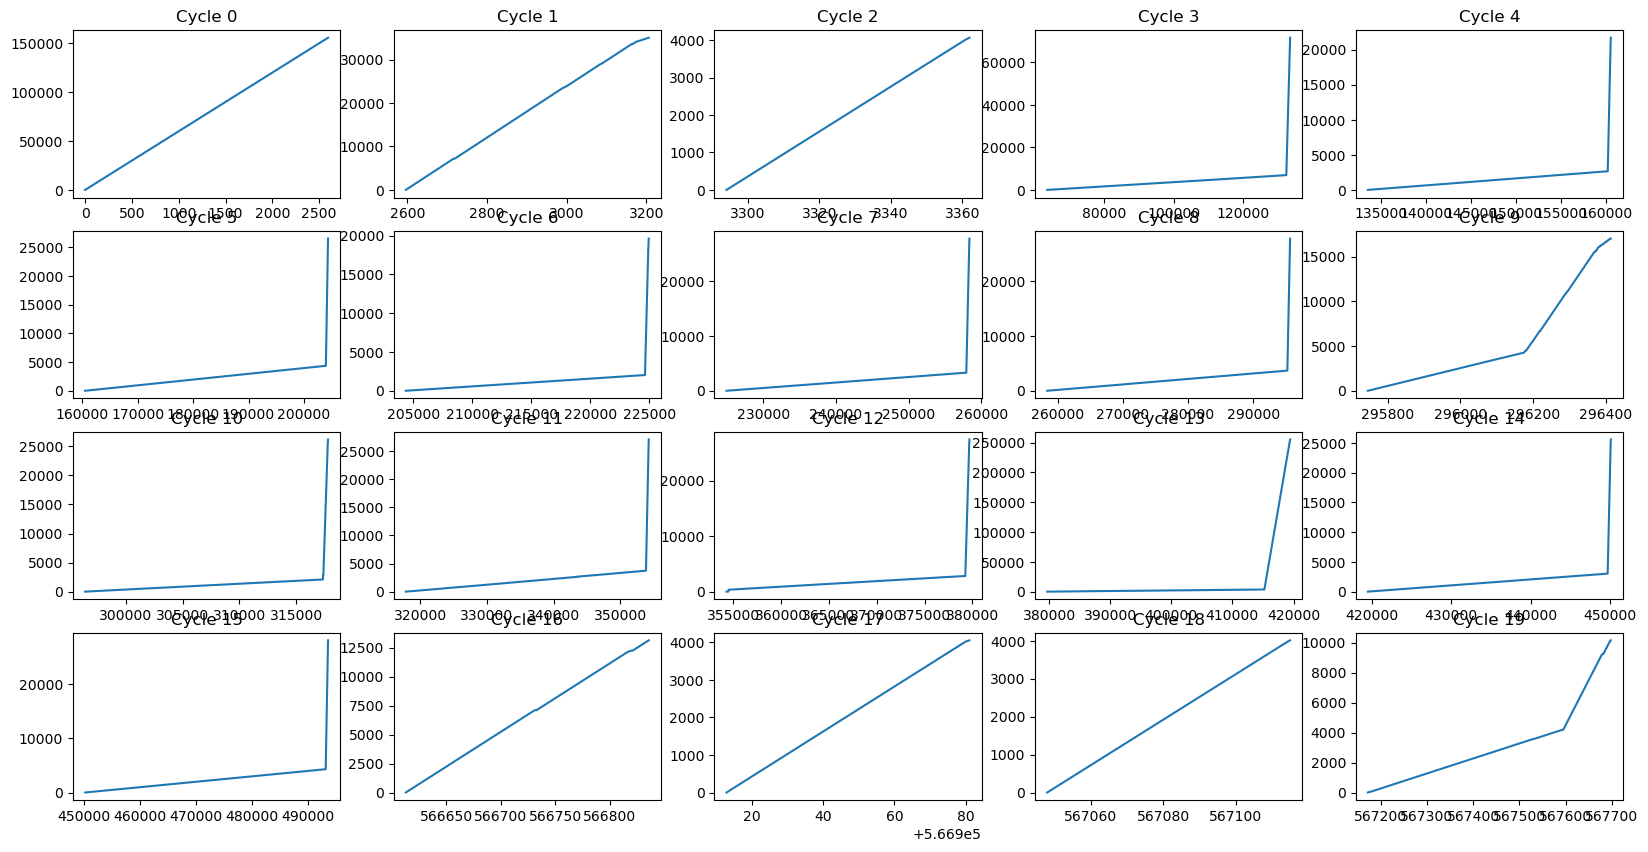

In [29]:
# plot all cycle_data cycle 't' into sub plots
fig, axes = plt.subplots(4, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
  if i >= len(cycle_data):
    break
  cycle_data[i]['cycle']['t'].plot(ax=ax)
  ax.set_title(f'Cycle {i}')

In [19]:
caps = []
feats = []

for i in range(len(cycle_data)):
  caps.append(cycle_data[i]['cap'])
  
  cycle = cycle_data[i]['cycle']
  time = cycle['t'].values / 60 # to minutes (align with MIT Stanford dataset)
  current = cycle['Current'].values
  temp = cycle['Temperature'].values
  feat = [
    np.trapz((current == 0).astype(np.float32), time),
    np.trapz((current > 0).astype(np.float32), time),
    np.trapz((current < 0).astype(np.float32), time),
    max(current),
    abs(min(current))
  ]
      
  for t in range(math.floor(min_temp), math.ceil(max_temp), temperature_feature_interval):
    feat = np.append(feat, np.trapz(((temp > t) & (temp <= t+temperature_feature_interval)).astype(np.float32), time))
  # only check charging current (I>0), as the discharge cycles are constant
  for c in range(0, math.ceil(max_current), current_feature_interval):
    feat = np.append(feat, np.trapz(((current > c) & (current <= c+current_feature_interval)).astype(np.float32), time))
  feats.append(feat)

In [20]:
cycle_data[30]['cycle']

,Time Stamp,Step,Status,Prog Time,Step Time,Cycle,Cycle Level,Procedure,Voltage,Current,...,Exp Temperature,Cycle Name,Exp Name,Index,Status Consecutive,Status Unique,Cycle Num,Prog Timestamp,Prog Time Delta,t
917112,3/21/2019 7:12:40 AM,57,TABLE,13:20:33.006,00:00:01.921,1,1,Samsung30T_CyclesB,4.18363,-0.07918,...,25degC,740_Mixed7,25degC: 740_Mixed7,917112,1031,TABLE1031,102.0,-2.208941e+09,0.000,0.000
917113,3/21/2019 7:12:40 AM,57,TABLE,13:20:33.103,00:00:02.018,1,1,Samsung30T_CyclesB,4.18245,-0.18134,...,25degC,740_Mixed7,25degC: 740_Mixed7,917113,1031,TABLE1031,102.0,-2.208941e+09,0.097,0.097
917114,3/21/2019 7:12:40 AM,57,TABLE,13:20:33.207,00:00:02.122,1,1,Samsung30T_CyclesB,4.18177,-0.23242,...,25degC,740_Mixed7,25degC: 740_Mixed7,917114,1031,TABLE1031,102.0,-2.208941e+09,0.104,0.201
917115,3/21/2019 7:12:40 AM,57,TABLE,13:20:33.301,00:00:02.216,1,1,Samsung30T_CyclesB,4.1816,-0.24264,...,25degC,740_Mixed7,25degC: 740_Mixed7,917115,1031,TABLE1031,102.0,-2.208941e+09,0.094,0.295
917116,3/21/2019 7:12:40 AM,57,TABLE,13:20:33.411,00:00:02.326,1,1,Samsung30T_CyclesB,4.18144,-0.24519,...,25degC,740_Mixed7,25degC: 740_Mixed7,917116,1031,TABLE1031,102.0,-2.208941e+09,0.110,0.405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946769,3/21/2019 9:35:05 AM,11,PAU,15:42:58.310,00:11:00.004,0,0,Slave_charge,4.18596,0.00000,...,25degC,740_Charge15,25degC: 740_Charge15,946769,1034,PAU1034,102.0,-2.208932e+09,60.006,8545.304
946770,3/21/2019 9:36:05 AM,11,PAU,15:43:58.310,00:12:00.004,0,0,Slave_charge,4.18563,0.00000,...,25degC,740_Charge15,25degC: 740_Charge15,946770,1034,PAU1034,102.0,-2.208932e+09,60.000,8605.304
946771,3/21/2019 9:37:05 AM,11,PAU,15:44:58.317,00:13:00.011,0,0,Slave_charge,4.18512,0.00000,...,25degC,740_Charge15,25degC: 740_Charge15,946771,1034,PAU1034,102.0,-2.208932e+09,60.007,8665.311
946772,3/21/2019 9:38:05 AM,11,PAU,15:45:58.313,00:14:00.007,0,0,Slave_charge,4.18478,0.00000,...,25degC,740_Charge15,25degC: 740_Charge15,946772,1034,PAU1034,102.0,-2.208932e+09,59.996,8725.307


In [21]:
for t in cycle_data[30]['cycle']['t'].values / 60:
  print(t)

0.0
0.001616668701171875
0.0033499956130981444
0.004916667938232422
0.006749995549519857
0.008283329010009766
0.010066668192545572
0.011616667111714682
0.013199996948242188
0.014983336130777994
0.016733336448669433
0.01833333174387614
0.019899996121724446
0.02156666914621989
0.02326666514078776
0.0250499963760376
0.026833335558573406
0.028199998537699382
0.030000003178914388
0.03155000209808349
0.03333333333333333
0.03486666679382324
0.03674999872843424
0.03826666673024495
0.039983336130777994
0.041550000508626304
0.043400001525878903
0.044916669527689614
0.04671666622161865
0.048366665840148926
0.05006666978200277
0.051566664377848306
0.05326666831970215
0.05500000317891439
0.056766668955485024
0.0584000031153361
0.05991666316986084
0.06163333257039388
0.06333333651224772
0.0650499979654948
0.0665333350499471
0.06823333104451497
0.06995000044504801
0.07170000076293945
0.07339999675750733
0.07491666475931803
0.07664999961853028
0.07833333015441894
0.08006666501363119
0.0815833330154418

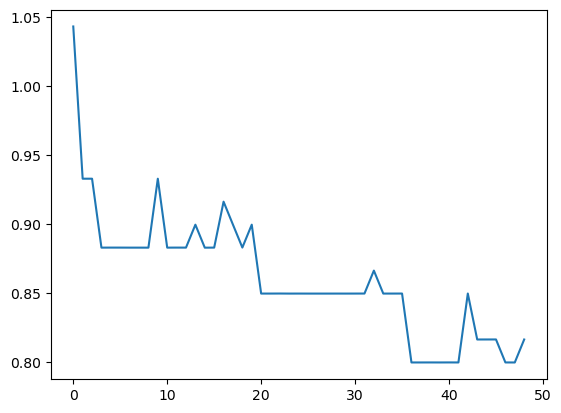

In [22]:
plt.plot(caps)

In [23]:
pre_processed_data = {
  'Samsung': {
    'capacities': torch.tensor(np.array(caps), dtype=torch.float32),
    'features': torch.tensor(np.array(feats), dtype=torch.float32)
  }
}

pickle.dump(pre_processed_data, open('preprocessed_data.pkl', 'wb'))

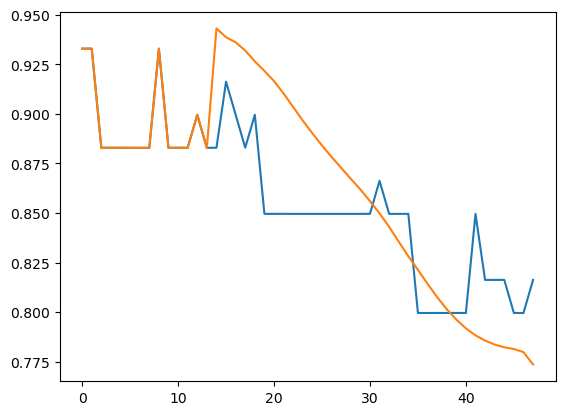

In [24]:
true_y = [[0.9329184889793396], [0.9329184889793396], [0.882914662361145], [0.8829429745674133], [0.8829359412193298], [0.882914662361145], [0.882914662361145], [0.8829004764556885], [0.9329043626785278], [0.882914662361145], [0.8829429745674133], [0.8829288482666016], [0.8995644450187683], [0.8828916549682617], [0.8829349875450134], [0.9162458181381226], [0.8995731472969055], [0.8829713463783264], [0.8995731472969055], [0.849597692489624], [0.849597692489624], [0.8496260046958923], [0.8495835065841675], [0.849597692489624], [0.8495835065841675], [0.8495835065841675], [0.8495835065841675], [0.8495905995368958], [0.8495835065841675], [0.849597692489624], [0.8496118187904358], [0.8662561774253845], [0.849597692489624], [0.849597692489624], [0.8496118187904358], [0.7996221780776978], [0.7996221780776978], [0.7996363043785095], [0.7996221780776978], [0.7996433973312378], [0.7996221780776978], [0.8496116399765015], [0.8162804841995239], [0.8162946701049805], [0.816308856010437], [0.79963618516922], [0.7996077537536621], [0.8162804841995239]]

pred_y = [[0.9329184889793396], [0.9329184889793396], [0.882914662361145], [0.8829429745674133], [0.8829359412193298], [0.882914662361145], [0.882914662361145], [0.8829004764556885], [0.9329043626785278], [0.882914662361145], [0.8829429745674133], [0.8829288482666016], [0.8995644450187683], [0.8828916549682617], [0.9430854320526123], [0.9386641979217529], [0.9361072182655334], [0.9319667220115662], [0.9264967441558838], [0.9216888546943665], [0.9165723323822021], [0.9102811217308044], [0.9034615159034729], [0.896624743938446], [0.890201985836029], [0.8840979337692261], [0.87828528881073], [0.8728147149085999], [0.8673103451728821], [0.8619363307952881], [0.8560587763786316], [0.8498607873916626], [0.8430495262145996], [0.8355885148048401], [0.8282204270362854], [0.8213783502578735], [0.814335286617279], [0.8076428771018982], [0.8015398979187012], [0.7962960600852966], [0.7918697595596313], [0.7883439660072327], [0.7856875061988831], [0.783692479133606], [0.7823361754417419], [0.7814517021179199], [0.7798908948898315], [0.7736524343490601]]

plt.plot(true_y)
plt.plot(pred_y)

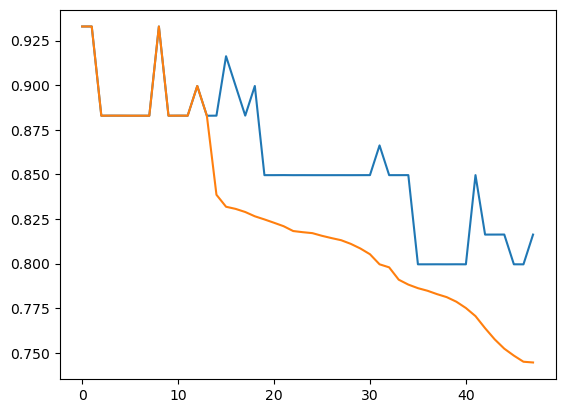

In [25]:
true_y = [[0.9329184889793396], [0.9329184889793396], [0.882914662361145], [0.8829429745674133], [0.8829359412193298], [0.882914662361145], [0.882914662361145], [0.8829004764556885], [0.9329043626785278], [0.882914662361145], [0.8829429745674133], [0.8829288482666016], [0.8995644450187683], [0.8828916549682617], [0.8829349875450134], [0.9162458181381226], [0.8995731472969055], [0.8829713463783264], [0.8995731472969055], [0.849597692489624], [0.849597692489624], [0.8496260046958923], [0.8495835065841675], [0.849597692489624], [0.8495835065841675], [0.8495835065841675], [0.8495835065841675], [0.8495905995368958], [0.8495835065841675], [0.849597692489624], [0.8496118187904358], [0.8662561774253845], [0.849597692489624], [0.849597692489624], [0.8496118187904358], [0.7996221780776978], [0.7996221780776978], [0.7996363043785095], [0.7996221780776978], [0.7996433973312378], [0.7996221780776978], [0.8496116399765015], [0.8162804841995239], [0.8162946701049805], [0.816308856010437], [0.79963618516922], [0.7996077537536621], [0.8162804841995239]]

pred_y = [[0.9329184889793396], [0.9329184889793396], [0.882914662361145], [0.8829429745674133], [0.8829359412193298], [0.882914662361145], [0.882914662361145], [0.8829004764556885], [0.9329043626785278], [0.882914662361145], [0.8829429745674133], [0.8829288482666016], [0.8995644450187683], [0.8828916549682617], [0.8386006355285645], [0.8318842649459839], [0.830681562423706], [0.8289414644241333], [0.8265371322631836], [0.8247820138931274], [0.8229131698608398], [0.8209816217422485], [0.8182693719863892], [0.8176265954971313], [0.8170952796936035], [0.8155900239944458], [0.8143129348754883], [0.8131263256072998], [0.8110897541046143], [0.8084927797317505], [0.8052773475646973], [0.7996279001235962], [0.7979201078414917], [0.7909994125366211], [0.788253664970398], [0.7862573862075806], [0.7847957611083984], [0.7828947305679321], [0.7812305688858032], [0.7786794900894165], [0.7751321792602539], [0.7705919742584229], [0.763821005821228], [0.7575790882110596], [0.7523491382598877], [0.7484537363052368], [0.7450217008590698], [0.7446073293685913]]

plt.plot(true_y)
plt.plot(pred_y)

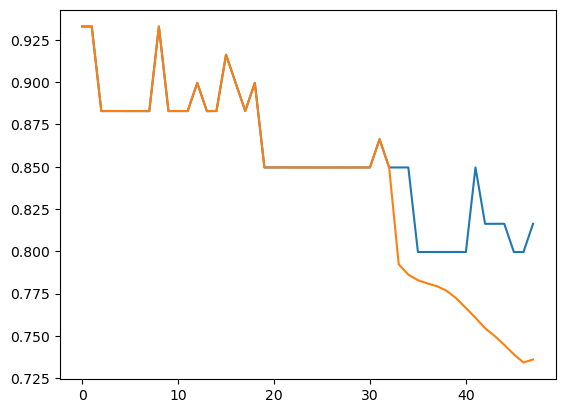

In [26]:
true_y = [[0.9329184889793396], [0.9329184889793396], [0.882914662361145], [0.8829429745674133], [0.8829359412193298], [0.882914662361145], [0.882914662361145], [0.8829004764556885], [0.9329043626785278], [0.882914662361145], [0.8829429745674133], [0.8829288482666016], [0.8995644450187683], [0.8828916549682617], [0.8829349875450134], [0.9162458181381226], [0.8995731472969055], [0.8829713463783264], [0.8995731472969055], [0.849597692489624], [0.849597692489624], [0.8496260046958923], [0.8495835065841675], [0.849597692489624], [0.8495835065841675], [0.8495835065841675], [0.8495835065841675], [0.8495905995368958], [0.8495835065841675], [0.849597692489624], [0.8496118187904358], [0.8662561774253845], [0.849597692489624], [0.849597692489624], [0.8496118187904358], [0.7996221780776978], [0.7996221780776978], [0.7996363043785095], [0.7996221780776978], [0.7996433973312378], [0.7996221780776978], [0.8496116399765015], [0.8162804841995239], [0.8162946701049805], [0.816308856010437], [0.79963618516922], [0.7996077537536621], [0.8162804841995239]]

pred_y = [[0.9329184889793396], [0.9329184889793396], [0.882914662361145], [0.8829429745674133], [0.8829359412193298], [0.882914662361145], [0.882914662361145], [0.8829004764556885], [0.9329043626785278], [0.882914662361145], [0.8829429745674133], [0.8829288482666016], [0.8995644450187683], [0.8828916549682617], [0.8829349875450134], [0.9162458181381226], [0.8995731472969055], [0.8829713463783264], [0.8995731472969055], [0.849597692489624], [0.849597692489624], [0.8496260046958923], [0.8495835065841675], [0.849597692489624], [0.8495835065841675], [0.8495835065841675], [0.8495835065841675], [0.8495905995368958], [0.8495835065841675], [0.849597692489624], [0.8496118187904358], [0.8662561774253845], [0.849597692489624], [0.7923396825790405], [0.786243200302124], [0.7829573154449463], [0.7810325622558594], [0.7794080972671509], [0.7766598463058472], [0.7722355127334595], [0.7665286064147949], [0.7607362270355225], [0.7545750141143799], [0.749991774559021], [0.7447634935379028], [0.7391471862792969], [0.7343368530273438], [0.7361027002334595]]

plt.plot(true_y)
plt.plot(pred_y)